#  spectra at AuxTel for Planetary Nebula

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : September 22th  2021



- **kernel anaconda3_auxtel**

# Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

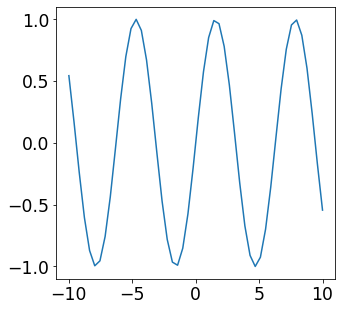

In [15]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [16]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [17]:
from datetime import datetime,date

In [18]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [19]:
string_date

'2021-09-23'

In [20]:
from iminuit import Minuit
import iminuit

In [21]:
iminuit.__version__

'2.7.0'

In [95]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [23]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [24]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [25]:
from time import sleep

In [26]:
from astropy.time import Time
import astropy.units as u

# Function

In [27]:
def file_target(filename):
    m=re.findall('^holo4_003_.*_(.*)_[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*_quickLoopExp[.]fits$',filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []

# Path

In [28]:
HOSTCC=False

In [29]:
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    #path_images=os.path.join(path_auxtel,"data/2021/holo/localreduced/2021-07-06")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp/2021-09-09")
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/softs/github/lsst/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    #path_images=os.path.join(path_auxtel,"data/2021/holo/localreduced/2021-07-06")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp/2021-09-09")

In [30]:
#config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")

# standard configuration
# config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY (dispersion rotation angle)
config="./config/auxtel_PNG.ini"

# Logbook for file selection

In [31]:
! ls logbooks

auxtelholologbook_2021_07_06_v2.0.csv
auxtelholologbook_2021_07_06_v2.0.xlsx
auxtelholologbook_2021_07_07_v3.0.csv
auxtelholologbook_2021_07_07_v3.0.xlsx
auxtelholologbook_PNG_2021_09_09_v2.0.csv
auxtelholologbook_PNG_2021_09_09_v2.0.xlsx


In [32]:
filename_logbook='logbooks/auxtelholologbook_PNG_2021_09_09_v2.0.csv'

In [33]:
df=pd.read_csv(filename_logbook,index_col=0)

In [34]:
pd.set_option('display.max_rows', None)

In [35]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-09-09T23:53:55.100,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000165_...,165,PNG321.0+03.9,empty_1,holo4_003,1.380357,10.0,...,9.2,16.0,4.0,300.0,1750.0,NaN,NaN,,1.0,1.0
1,1,2021-09-09T23:54:18.095,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000166_...,166,PNG321.0+03.9,empty_1,holo4_003,1.381613,10.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
2,2,2021-09-09T23:54:41.122,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000167_...,167,PNG321.0+03.9,empty_1,holo4_003,1.382874,10.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
3,3,2021-09-09T23:55:04.180,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000168_...,168,PNG321.0+03.9,empty_1,holo4_003,1.384148,30.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
4,4,2021-09-09T23:55:47.196,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000169_...,169,PNG321.0+03.9,empty_1,holo4_003,1.386523,30.0,...,9.0,17.0,3.1,300.0,1750.0,NaN,NaN,,1.0,1.0
5,5,2021-09-09T23:56:30.224,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000170_...,170,PNG321.0+03.9,empty_1,holo4_003,1.388908,30.0,...,9.0,16.0,3.9,300.0,1750.0,NaN,NaN,,1.0,1.0
6,6,2021-09-09T23:57:13.142,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000171_...,171,PNG321.0+03.9,empty_1,holo4_003,1.391300,60.0,...,9.0,16.0,3.9,300.0,1750.0,NaN,NaN,,1.0,1.0
7,7,2021-09-10T00:04:18.230,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000174_...,174,PNG321.0+03.9,empty_1,holo4_003,1.415803,0.0,...,8.9,15.0,3.7,300.0,1750.0,NaN,NaN,,1.0,1.0
8,8,2021-09-10T00:06:01.239,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000175_...,175,PNG321.0+03.9,empty_1,holo4_003,1.421962,60.0,...,8.9,15.0,3.8,300.0,1750.0,NaN,NaN,,1.0,1.0
9,9,2021-09-10T00:07:14.156,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000176_...,176,PNG321.0+03.9,empty_1,holo4_003,1.426365,60.0,...,8.9,15.0,4.4,300.0,1750.0,NaN,NaN,,1.0,1.0


# Selection of input file

In [36]:
df_good=df[df["quality"]==1]

In [37]:
for spectra_file in df_good["file"]:
    print(spectra_file)

holo4_003_empty_PNG321.0+03.9_20210909_000165_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000166_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000167_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000168_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000169_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000170_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000171_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000174_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000175_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000176_quickLookExp.fits
holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits


In [38]:
#dir_spectra="outputs_reprocess"
dir_spectra="outputs_process_holo_PNG"

In [39]:
! ls $dir_spectra

holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_lines.csv
holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrogram.fits
holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits
holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_table.csv


In [40]:
all_files=os.listdir(dir_spectra)

In [41]:
all_spectra_files = []
for filename in all_files:
    if re.search("_spectrum.fits$",filename):
        all_spectra_files.append(filename)
N=len(all_spectra_files)

In [42]:
all_spectra_files

['holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits']

In [43]:
df_good["file"].values

array(['holo4_003_empty_PNG321.0+03.9_20210909_000165_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000166_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000167_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000168_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000169_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000170_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000171_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000174_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000175_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000176_quickLookExp.fits',
       'holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits'],
      dtype=object)

In [44]:
all_good_spectra_spectrum_files=[]

idx=0
for good_spectra_file in df_good["file"].values:
    good_spectra_spectrum_file = good_spectra_file.split(".fits")[0]+"_spectrum.fits"
    if good_spectra_spectrum_file in all_spectra_files:
        print(idx,") : found {}".format(good_spectra_spectrum_file))
        all_good_spectra_spectrum_files.append(good_spectra_spectrum_file)
        idx+=1

0 ) : found holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits


In [45]:
all_good_spectra_spectrum_files

['holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits']

0 ) holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits   outputs_process_holo_PNG/holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits


/users/dagoret/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


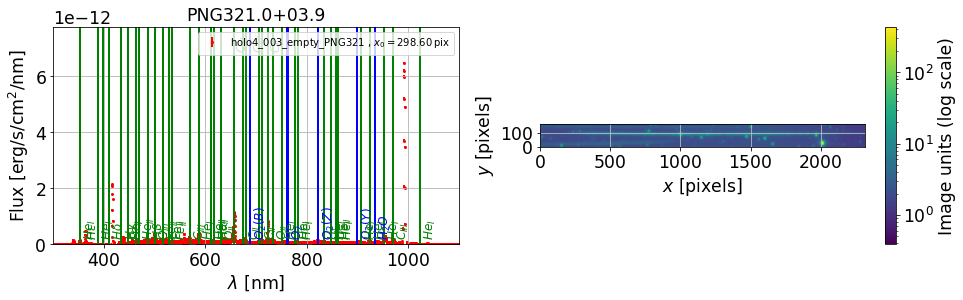

In [46]:
parameters.DISPLAY=False

infos = []

idx=0
for filename in all_good_spectra_spectrum_files:
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    fullfilename = os.path.join(dir_spectra,filename)
    
    print(idx,")",filename," ",fullfilename)
    
    
    #try:
    #    s=Spectrum(fullfilename, config="config/auxtel_quicklook.ini")
    #    print("Success First Connection with file "+ fullfilename)
    #    break           
    #except requests.exceptions.ConnectionError:
    #except:
    #    print("Connection refused, will retry")
    #    sleep(5)
    #    try:
    #        print("try connection again ")    
    #        s=Spectrum(fullfilename, config="config/auxtel_quicklook.ini")
    #        print("Success Second Connection ")
    #        break
        
        #except requests.exceptions.ConnectionError:
    #    except:
    #        print("Connection refused twice, give up")
    #        continue
            
    #    continue
                   
    
    s=Spectrum(fullfilename, config=config)
    label=filename.split('.')[0]+" "
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=fullfilename.replace("_spectrum","_spectrogram")
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    idx+=1
    

# Selection of the spectrum

In [53]:
IDXSEL=0
filename_SEL=all_good_spectra_spectrum_files[IDXSEL]

In [58]:
! ls $dir_spectra

holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_lines.csv
holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrogram.fits
holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrum.fits
holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_table.csv


In [59]:
IDXSEL=0
filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
filename_lines_SEL=filename_SEL.replace("_spectrum.fits","_lines.csv")
filename_table_SEL=filename_SEL.replace("_spectrum.fits","_table.csv")

fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
fullfilename_lines_SEL = fullfilename_SEL.replace("_spectrum.fits","_lines.csv")
fullfilename_table_SEL = fullfilename_SEL.replace("_spectrum.fits","_table.csv")

In [70]:
spectrogram_hdu=fits.open(fullfilename_spectrogram_SEL)

In [71]:
spectrogram_hdu.info()

Filename: outputs_process_holo_PNG/holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp_spectrogram.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPECTRUM      1 PrimaryHDU     144   (2317, 161)   float64   
  1  S_ERR         1 ImageHDU         8   (2317, 161)   float64   
  2  S_BGD         1 ImageHDU         8   (2317, 161)   float64   
  3  S_BGD_ER      1 ImageHDU         8   (2317, 161)   float64   
  4  S_FIT         1 ImageHDU         7   (94997,)   float64   
  5  S_RES         1 ImageHDU         7   (94997,)   float64   


In [72]:
spectrogram_image= spectrogram_hdu[0].data

In [61]:
df_lines=pd.read_csv(fullfilename_lines_SEL,index_col=0)

In [85]:
df_lines

,Tabulated,Detected,Shift,FWHM,Amplitude,SNR,Chisq,Eqwidth_mod,Eqwidth_data
Line,,,,,,,,,
$He_{I}$,353.100006,353.539215,0.439209,12.301182,5.542675e-13,33.857941,5.921208,16.778606,37.687027
$H\delta$,410.200012,416.203583,6.003572,2.035535,1.781530e-12,60.226051,7.693915,106.855576,99.469383
$H\gamma$,434.000000,435.369019,1.369012,10.925664,1.302364e-13,4.402746,7.693915,61.229847,445.765350
$Fe_{II}$,463.799988,462.793549,-1.006466,10.770501,9.898949e-14,3.346420,7.693915,-210.797516,18.782858
$H\beta$,486.299988,483.617798,-2.682187,10.086087,9.304618e-14,3.145502,7.693915,-23.642406,-83.452217
$C_{III}$,570.000000,567.941833,-2.058148,1.316775,1.184273e-13,3.314552,6.447922,-1.157499,-0.468868
$He_{I}$,587.500000,586.843079,-0.656949,1.898447,3.562328e-13,9.970273,6.447922,-10.029447,-10.576116
$He_{II}$,611.799988,610.040710,-1.759311,10.209607,1.091966e-13,3.153793,0.566669,22.615515,32.493732
$He_{II}$,617.099976,618.433289,1.333315,13.462131,1.071089e-13,3.093495,0.566669,-73.350548,-23.158998


In [87]:
df_lines.columns

Index(['Tabulated', 'Detected', 'Shift', 'FWHM', 'Amplitude', 'SNR', 'Chisq',
       'Eqwidth_mod', 'Eqwidth_data'],
      dtype='object')

In [90]:
df_lines.index[0]

'$He_{I}$'

In [124]:
idx=0
all_lines = []
for index, row in df_lines.iterrows():
    print(df_lines.index[idx], row['Tabulated'])
    line = Line(row['Tabulated'], label=df_lines.index[idx], atmospheric=False , emission=True, label_pos=[0, 0.8])
    if row['SNR']>5:
        all_lines.append(line)
    idx+=1

$He_{I}$ 353.1000061035156
$H\delta$ 410.2000122070313
$H\gamma$ 434.0
$Fe_{II}$ 463.7999877929688
$H\beta$ 486.2999877929688
$C_{III}$ 570.0
$He_{I}$ 587.5
$He_{II}$ 611.7999877929688
$He_{II}$ 617.0999755859375
$H\alpha$ 656.2999877929688
$C_{II}$ 679.0
$C_{II}$ 723.5
nan 760.2999877929688
$O_2(Y)$ 898.7650146484375
$He_{I}$ 923.5
$He_{I}$ 951.9000244140624
$C_{III}$ 970.5


In [125]:
lines_collection=Lines(all_lines)

In [126]:
df_table=pd.read_csv(fullfilename_table_SEL)

In [127]:
df_table.head()

,lambdas,Dx,Dy,Dy_disp_axis,flux_sum,flux_integral,flux_err,fwhm,Dy_fwhm_sup,Dy_fwhm_inf,amplitude,x_c,y_c,gamma,alpha,saturation
0,302.549634,851.313841,17.163696,-6.629468,3.694844,1.0,4.538023,8.003827,33.971595,0.355797,1.0,0.0,97.882646,4.271057,1.1,2837.792561
1,302.904250,852.313841,17.153542,-6.637256,-8.545156,1.0,4.519271,8.031159,33.951344,0.355740,1.0,1.0,97.872492,4.285419,1.1,2837.792561
2,303.258864,853.313841,17.143392,-6.645043,-25.644430,1.0,4.492414,8.056528,33.931097,0.355687,1.0,2.0,97.862342,4.299767,1.1,2837.792561
3,303.613474,854.313841,17.133247,-6.652830,-38.610742,1.0,4.471998,8.085500,33.910855,0.355639,1.0,3.0,97.852197,4.314101,1.1,2837.792561
4,303.968082,855.313841,17.123107,-6.660618,-33.911841,1.0,4.480427,8.110856,33.890618,0.355596,1.0,4.0,97.842057,4.328421,1.1,2837.792561


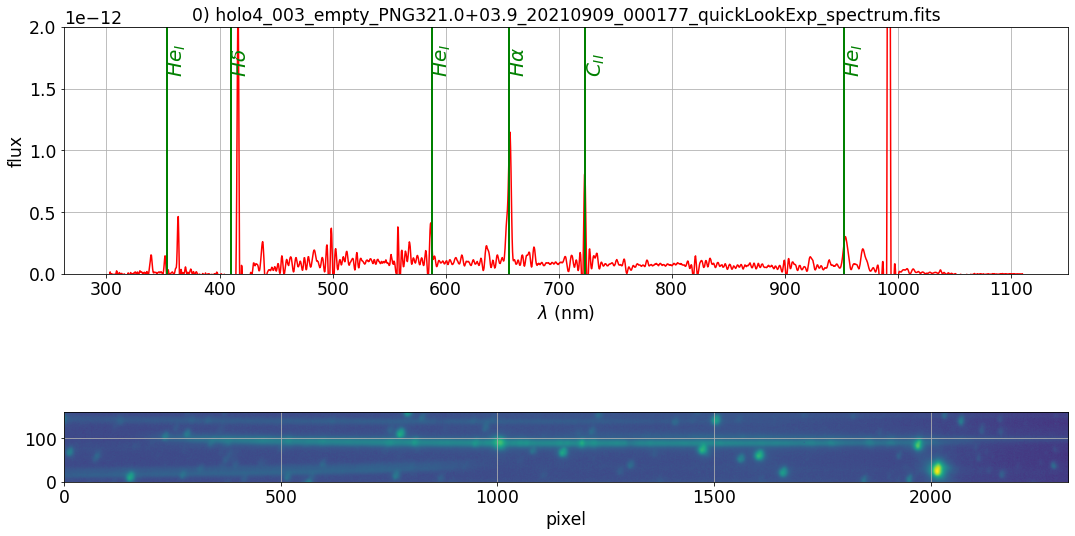

In [128]:
fig = plt.figure(figsize=(18,10))
ax=fig.add_subplot(2,1,1)
ax.plot(s.lambdas,s.data,"r-")
thetitle=str(IDXSEL)+") "+ filename_SEL
ax.set_title(thetitle)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux")
ax.grid()
ax.set_ylim(0,2e-12)
lines_collection.plot_atomic_lines(ax, color_atomic='g', color_atmospheric='b', fontsize=20, force=True)
ax=fig.add_subplot(2,1,2)
ax.imshow(spectrogram_image,origin="lower",norm=LogNorm())
ax.grid()
ax.set_xlabel("pixel")
plt.show()

In [ ]:
alert False

In [ ]:
df_infos=pd.DataFrame(infos,columns=["idx","date_obs","airmass","temperature","pressure","humidity"])

In [ ]:
df_infos.set_index('idx',inplace=True)

In [ ]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [ ]:
all_reftime=np.array(all_reftime)

In [ ]:
df_infos["reftime"]=all_reftime

In [ ]:
df_infos["eqw_h2o"] = np.nan
df_infos["eqw_o2"] = np.nan
df_infos["eqw_o2_spec"] = np.nan

In [ ]:
df_infos

# Selection of spectra and equivalent width calculation

In [ ]:
from astropy import units as u
from astropy.visualization import quantity_support

quantity_support()  # for getting units on the axes below  

In [ ]:
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum,fit_continuum
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from astropy.modeling import models
from specutils.manipulation import extract_region

In [ ]:
IDXSEL=0
filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
filename_lines_SEL=filename_SEL.replace("_spectrum.fits","_lines.csv")
filename_table_SEL=filename_SEL.replace("_spectrum.fits","_table.csv")
fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
fullfilename_lines_SEL = fullfilename_SEL.replace("_spectrum.fits","_lines.csv")
fullfilename_table_SEL = fullfilename_SEL.replace("_spectrum.fits","_table.csv")

In [ ]:
fullfilename_table_SEL

In [ ]:
thetitle=str(IDXSEL)+") "+filename_SEL

In [ ]:
thetitle

In [ ]:
fullfilename_SEL

## Load spectrum and Spectrogram

In [ ]:
s=Spectrum(fullfilename_SEL, config=config)
s.load_spectrogram(fullfilename_spectrogram_SEL) 

In [ ]:
df_lines=pd.read_csv(fullfilename_lines_SEL,index_col=0)

In [ ]:
df_lines

In [ ]:
lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)

In [ ]:
s.lines = lines

In [ ]:
lambdas = np.arange(300,1000,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)

In [ ]:
# global_chisq = detect_lines(lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)

In [ ]:
fig = plt.figure(figsize=(18,10))
plot_spectrum_simple(plt.gca(), s.lambdas, s.data, s.err)
lines.plot_detected_lines(plt.gca())
thetitle=str(IDXSEL)+") "+ filename_SEL
plt.title(thetitle)
plt.show()

In [ ]:
# lines.print_detected_lines()

In [ ]:
alert False

## with specutils

### Convert in specutils units

In [ ]:
lamb = 10*s.lambdas * u.AA 
flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10. 
fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

## Equivalent width calculation with Automatic line plot

In [ ]:
def ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=None,ax2=None):
    """
    
    ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True)
    
    - input :
    
    
    - output :
    
    """
            
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
    
    eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
    eqw2=equivalent_width(cont_norm_spec, regions=sub_region)  
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\AA$ ".format(eqw1.value)
        eqw_str2="$Eqw_2$ = {:2.2f} $\AA$ ".format(eqw2.value)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline,color='r')
        ax1.axvline(wlmaxline,color="r")
        ax1.axvline(wlmin,color='g')
        ax1.axvline(wlmax,color="g")
        ax1.set_ylim(YMIN,YMAX)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline,color='r')
        ax2.axvline(wlmaxline,color="r")
        ax2.axvline(wlmin,color='g')
        ax2.axvline(wlmax,color="g")
        ax2.set_ylim(0,2)
        ax2.text(0.05, 0.95, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
        
    return eqw1.value,eqw2.value     

In [ ]:
def ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=None,ax2=None):
    """
    
    ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline)
    
    - input :
    
    
    - output :
    
    """
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
         
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
       
    eqw10=equivalent_width(cont_norm_spec, regions=line_region).value 
    eqw20=equivalent_width(cont_norm_spec, regions=sub_region).value 
       
    # Bootstrap
    
    
    eqw1_set=np.zeros(NN)
    eqw2_set=np.zeros(NN)
    size=len(specerr.flux)
    
    # loop on trials 
    for idx in np.arange(NN):
        
        # random generator for errors
        s = np.random.normal(0, 1, size)
        
        # new flux
        newspec = Spectrum1D(spectral_axis=spec.spectral_axis, flux=spec.flux+specerr.flux*s)
              
    
        # region where one extract the spectrum
        sub_spectrum = extract_region(newspec, sub_region)
    
        # initialisaition of linear model
        g_init = models.Linear1D(slope=0,intercept=1e-12)
    
        # fit on sub-spectrum
        g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
        # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
        g2_fit = fit_continuum(newspec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
        y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
        y_continuum_fitted2 = g2_fit(newspec.spectral_axis)
    
        # normalize the spectrum
        cont_norm_spec = newspec/ y_continuum_fitted2 
    
    
        eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
        eqw2=equivalent_width(cont_norm_spec, regions=sub_region) 
        
        
        eqw1_set[idx]=eqw1.value
        eqw2_set[idx]=eqw2.value
        
     
    eqw1_std=eqw1_set.std()
    eqw2_std=eqw2_set.std()
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\pm$ {:2.2f} $\AA$ ".format(eqw10,eqw1_std)
        eqw_str2="$Eqw_2$ = {:2.2f} $\pm$ {:2.2f} $\AA$ ".format(eqw20,eqw2_std)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline,color='r')
        ax1.axvline(wlmaxline,color="r")
        ax1.axvline(wlmin,color='g')
        ax1.axvline(wlmax,color="g")
        ax1.set_ylim(YMIN,YMAX)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline,color='r')
        ax2.axvline(wlmaxline,color="r")
        ax2.axvline(wlmin,color='g')
        ax2.axvline(wlmax,color="g")
        ax2.set_ylim(0,2)
        ax2.text(0.05, 0.95, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
               
        
    return eqw10,eqw20,eqw1_set,eqw2_set     

### The original spectrum

#### O2 line

In [ ]:
wlmin=10*(O2_1.wavelength-30)*u.AA
wlmax=10*(O2_1.wavelength+30)*u.AA
wlminline=10*(O2_1.wavelength-10)*u.AA
wlmaxline=10*(O2_1.wavelength+10)*u.AA

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=30,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(eq1_set,bins=50,histtype='step',color='b');
ax1.axvline(eqw10,color='r')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq2_set,bins=50,histtype='step',color="b");
ax2.axvline(eqw20,color='r')
plt.suptitle(thetitle)

### H2O line

In [ ]:
wlmin=10*(H2O_1.wavelength-30)*u.AA
wlmax=10*(H2O_2.wavelength+30)*u.AA
wlminline=10*(H2O_1.wavelength-12)*u.AA
wlmaxline=10*(H2O_2.wavelength+10)*u.AA

In [ ]:
lamb = 10*s.lambdas * u.AA 
flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10. 
fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=30,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(eq1_set,bins=50,histtype='step',color='b');
ax1.axvline(eqw10,color='r')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq2_set,bins=50,histtype='step',color='b');
ax2.axvline(eqw20,color='r')
plt.suptitle(thetitle)

# Loop on spectra with Spectractor

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,7):
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    #wlidx=np.where(np.logical_and( s.lambdas>=WLMIN, s.lambdas<=WLMAX))[0]
    #print(wlidx)
    #wl=s.lambdas[wlidx]
    
    #specify the lines  
    lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)
    s.lines = lines
    
    global_chisq = detect_lines(lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)
    
    print(IDXSEL,") ",filename_SEL)
    thetitle=str(IDXSEL)+") "+filename_SEL
    
    fig = plt.figure(figsize=(10,5))
    plot_spectrum_simple(plt.gca(), s.lambdas, s.data, s.err)
    lines.plot_detected_lines(plt.gca())
    plt.title(thetitle)
    plt.show()
    
    print(lines.print_detected_lines())
    print(lines.print_detected_lines()[0]["Eqwidth_data"])
    df_infos.at[IDXSEL,"eqw_o2_spec"] = lines.print_detected_lines()[0]["Eqwidth_data"]*10.
    
    

In [ ]:
print(lines.print_detected_lines())

In [ ]:
type(lines.print_detected_lines())

In [ ]:
print(lines.print_detected_lines()[0]["Eqwidth_data"])

In [ ]:
df_infos

# Loop on spectrum, compute O2 line equivalent width with specutils 

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,8):

    
    
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    
    print(IDXSEL,") ",filename_SEL)
    
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    
    lamb = 10*s.lambdas * u.AA 
    flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
    specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)
    
    # O2 line
    wlmin=10*(O2_1.wavelength-30)*u.AA
    wlmax=10*(O2_1.wavelength+30)*u.AA
    wlminline=10*(O2_1.wavelength-10)*u.AA
    wlmaxline=10*(O2_1.wavelength+10)*u.AA
    
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    #eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
    eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=ax1,ax2=ax2)
    thetitle=str(IDXSEL)+") "+filename_SEL
    plt.suptitle(thetitle,y=1.01)
    plt.show() 
    
    print(IDXSEL,") eqw_O2=",eqw10)
    
    df_infos.at[IDXSEL,"eqw_o2"] =  eqw10

# Loop on spectrum, compute H2O line equivalent width with specutils 

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,8):
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    
    lamb = 10*s.lambdas * u.AA 
    flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
    specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)
    
    # H2O line
    
    wlmin=10*(H2O_1.wavelength-30)*u.AA
    wlmax=10*(H2O_2.wavelength+30)*u.AA
    wlminline=10*(H2O_1.wavelength-12)*u.AA
    wlmaxline=10*(H2O_2.wavelength+10)*u.AA
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    eqw1,eqw2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
    #eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=ax1,ax2=ax2)
    thetitle=str(IDXSEL)+") "+filename_SEL
    plt.suptitle(thetitle,y=1.01)
    plt.show() 
    
    print(IDXSEL,") eqw_O2=",eqw1)
    
    df_infos.at[IDXSEL,"eqw_h2o"] =  eqw1

In [ ]:
df_infos

In [ ]:
df_infos.to_csv("eqw.csv")

In [ ]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['eqw_o2'],marker="o",color="red",label="$eqw(O_2)$");
ax.plot(df_infos['date_obs'], df_infos['eqw_h2o'],marker="o",color="blue",label="$eqw(H_2O)$");
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="green",label="airmass")
ax2.set_ylim(1,1.5)
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax.set_title("Equivalent Widths vs date")

In [ ]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
df_infos.plot(ax=ax,x="date_obs", y=["eqw_o2","eqw_h2o"],color=["r","b"],marker="o");
#plt.gcf().autofmt_xdate(rotation=90) 
ax.xaxis.set_tick_params(rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax.set_yscale("log")

ax2 = ax.twinx()
df_infos.plot(ax=ax2,x="date_obs", y="airmass",color=["g"],marker="o",lw=0);
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax2.set_ylim(1,2)
ax2.xaxis.set_tick_params(rotation=90)
ax.set_title("Equivalent Widths vs date")


In [ ]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['reftime'], df_infos['eqw_o2'],marker="o",color="red",label="$eqw(O_2)$");
ax.plot(df_infos['reftime'], df_infos['eqw_h2o'],marker="o",color="blue",label="$eqw(H_2O)$");
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax2 = ax.twinx()
ax2.plot(df_infos['reftime'], df_infos['airmass'],linestyle='dotted', marker='.',color="green",label="airmass",lw=0)
ax2.set_ylim(1,1.5)
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax.set_title("Equivalent Widths vs date")